In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
def updateSubmission(predictions):

    test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
    output = pd.DataFrame({'Id': test_data.index, 'SalePrice': predictions.flatten()})
    output.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")
    print(output)
    
def prepareSubmission(model, X_train, y_train, X_test):

    model.fit(X_train,y_train)

    predictions = model.predict(X_test)
    
    return predictions

In [3]:
def make_mi_scores(X,y):
    X = X.copy()
    for colname in X.select_dtypes(["object","category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X,y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [4]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import lightgbm as lgbm
import catboost as cb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import RadiusNeighborsRegressor,KNeighborsRegressor
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error , mean_squared_log_error
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression
from category_encoders import MEstimateEncoder, TargetEncoder
from math import sqrt
from sklearn.feature_selection import mutual_info_regression

In [5]:
pd.set_option('max_columns', None)

In [6]:
pd.reset_option('max_columns')

In [7]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

## Data Preprocessing

***

In [8]:
def clean(df):
    df.rename(columns={'BedroomAbvGr':'Bedroom','1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecFlrSF','KitchenAbvGr':'Kitchen'}, inplace=True)
    df['Neighborhood'] = df['Neighborhood'].replace({'NAmes':'Names'})
    df['BldgType'] = df['BldgType'].replace({'2fmCon':'2FmCon'})
    df['Exterior2nd'] = df['Exterior2nd'].replace({'CmentBd':'CemntBd','Brk Cmn':'BrkComm'})
    df['MasVnrType'] = df['MasVnrType'].replace({'BrkCmn':'BrkComm'})
    df['YearRemodAdd'] = np.where(df.YearRemodAdd < df.YearBuilt,df.YearBuilt, df.YearRemodAdd)
    df['GarageYrBlt'] = np.where(df.GarageYrBlt < df.YearBuilt,df.YearBuilt, df.GarageYrBlt)
    
    return df
def encode(df):

    replace_values = {'Ex': 4,'Gd' : 3,'TA':2,'Fa':1, 'Po':0, 'None': 0}
    
    df['ExterQual'] = df['ExterQual'].replace(replace_values) 
    df['ExterCond'] = df['ExterCond'].replace(replace_values) 
    df['BsmtQual'] = df['BsmtQual'].replace(replace_values) 
    df['BsmtCond'] = df['BsmtCond'].replace(replace_values) 
    df['BsmtExposure'] = df['BsmtExposure'].replace({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0}) 
    df['BsmtFinType1'] = df['BsmtFinType1'].replace({'GLQ':5,'ALQ':4,'BLQ':3,'Rec':2,'LwQ':1,'Unf':0,'None':0}) 
    df['BsmtFinType2'] = df['BsmtFinType2'].replace({'GLQ':5,'ALQ':4,'BLQ':3,'Rec':2,'LwQ':1,'Unf':0,'None':0}) 
    df['HeatingQC'] = df['HeatingQC'].replace(replace_values)
    df['CentralAir'] = df['CentralAir'].replace({'Y':1,'N':0,'None':0}) 
    df['KitchenQual'] = df['KitchenQual'].replace(replace_values) 
    df['FireplaceQu'] = df['FireplaceQu'].replace(replace_values) 
    df['GarageQual'] = df['GarageQual'].replace(replace_values) 
    df['GarageCond'] = df['GarageCond'].replace(replace_values) 
    df['FireplaceQu'] = df['FireplaceQu'].replace(replace_values) 

    df['HouseStyle'].replace({'1Story':'1','1.5Fin':'1.5','1.5Unf':'1.5','2Story':'2','2.5Fn':'2.5','2.5Unf':'2.5','SFoyer':'S','SLvl':'S'})
    df['CM_OverallQualCondRatio'] = df['OverallQual'] * df['OverallCond']
    df['CM_YearDiffBuiltRemod'] = df['YearRemodAdd'] - df['YearBuilt']
    df['CM_BathCount'] = df[['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']].sum(axis=1)
    df['CM_PorchArea'] = df[['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','WoodDeckSF']].sum(axis=1)
    df['CM_PorchType'] = df[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].gt(0.0).sum(axis=1)
    df['CM_GarageAreaCarRatio'] = df['GarageCars'] / df['GarageArea']
    df['CM_GarageYearBuiltDiff'] = (df.GarageYrBlt - df.YearBuilt)
    df['CM_FirstSecondFlrBsmtTotal'] = df.FirstFlrSF + df.SecFlrSF + df.TotalBsmtSF
    df['CM_YearBltSoldDiff'] =  df.YrSold - df.YearBuilt
    df['CM_GarageAreaQC'] = df.GarageArea * df.GarageCond * df.GarageQual
    df['CM_BsmtFinishedQC'] = df.BsmtFinSF1 * df.BsmtFinType1  + df.BsmtFinSF2 * df.BsmtFinType2
    df['CM_BsmtAreaExposureRatio'] = df.TotalBsmtSF / (df.BsmtExposure + 0.1)
    df['CM_FireplaceQualRatio'] = df.Fireplaces / (df.FireplaceQu + 0.1)
    
    for colname in df.select_dtypes(["category", "object"]):
        df[colname], _ = df[colname].factorize()
    
    return df
def impute(df):
    
    columns = df.columns
    
    for col in df.select_dtypes('object').columns:
        df[col].fillna('None', inplace=True)

    return df

def prepare_data():
    
    train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
    test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
    
    df = pd.concat([train_data, test_data])

    df = clean(df)
    df = impute(df)
    df = encode(df)

    col_to_drop = ['Utilities', 'PoolArea','PoolQC','Fence','MiscFeature','MiscVal','Alley','LotFrontage','MoSold','Street','Condition2','LandSlope']
    col_to_drop_2 = ['YearRemodAdd','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','WoodDeckSF',
                    'GarageCars','GarageArea','YrSold','FirstFlrSF','SecFlrSF','TotalBsmtSF','BsmtFinSF1','BsmtFinType1','BsmtFinSF2','BsmtFinType2','BsmtExposure']
    
    df.drop(columns = col_to_drop + col_to_drop_2, inplace=True)
    train_data = df.loc[train_data.index, :]
    test_data = df.loc[test_data.index, :]

    return train_data, test_data

In [9]:
df_train, df_test =  prepare_data()
df_train_X = df_train.copy()
df_test.pop('SalePrice')
df_train_X.dropna(inplace=True)
df_train_y = df_train_X.pop('SalePrice')

CM_FirstSecondFlrBsmtTotal    0.666867
OverallQual                   0.555335
Neighborhood                  0.520528
CM_OverallQualCondRatio       0.445253
GrLivArea                     0.436879
YearBuilt                     0.397632
LotArea                       0.386634
CM_YearBltSoldDiff            0.358834
BsmtQual                      0.340227
CM_GarageAreaQC               0.323492
KitchenQual                   0.318327
ExterQual                     0.311943
CM_BathCount                  0.306790
CM_BsmtAreaExposureRatio      0.279509
GarageYrBlt                   0.270328
Name: MI Scores, dtype: float64


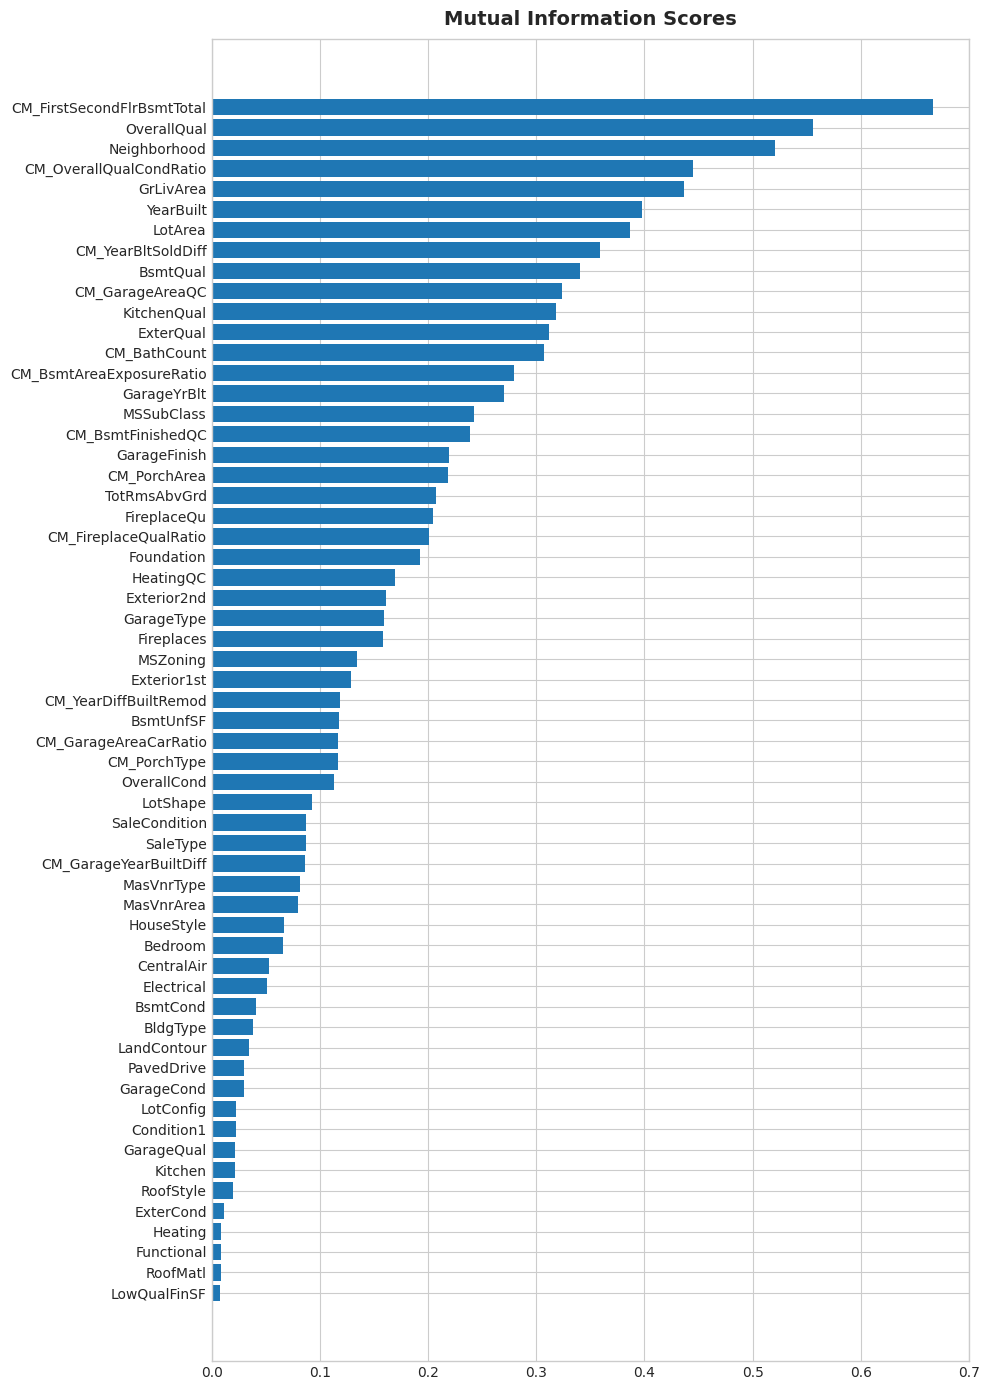

In [10]:
score = make_mi_scores(df_train_X,df_train_y)
print(score.head(15))
plt.figure(dpi=100, figsize=(10,14))
plot_mi_scores(score)

In [11]:
df_train.corr().sort_values('SalePrice', ascending=False)

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,CM_PorchArea,CM_PorchType,CM_GarageAreaCarRatio,CM_GarageYearBuiltDiff,CM_FirstSecondFlrBsmtTotal,CM_YearBltSoldDiff,CM_GarageAreaQC,CM_BsmtFinishedQC,CM_BsmtAreaExposureRatio,CM_FireplaceQualRatio
SalePrice,-0.084284,-0.116047,0.263843,0.267759,0.092009,0.109106,-0.143621,-0.044820,-0.112611,-0.188688,...,0.390993,0.409068,-0.034869,-0.176197,0.782260,-0.523350,0.576914,0.465282,-0.040278,0.017093
OverallQual,0.032628,-0.015122,0.105806,0.198994,0.039133,0.060576,-0.138913,-0.019525,0.022988,-0.178803,...,0.306097,0.403606,0.033649,-0.198701,0.668155,-0.572629,0.523377,0.334975,-0.001067,-0.019833
CM_FirstSecondFlrBsmtTotal,-0.082225,-0.137400,0.307234,0.243547,0.065044,0.097155,-0.103453,0.019535,-0.122734,-0.170682,...,0.397428,0.366869,-0.083244,-0.113040,1.000000,-0.347892,0.501018,0.457406,0.153107,0.021584
GrLivArea,0.074853,-0.061209,0.263116,0.212741,0.055967,0.099722,-0.058901,0.062618,-0.126722,-0.183808,...,0.381182,0.348614,-0.015565,-0.000337,0.874373,-0.200302,0.419244,0.250158,0.066843,0.026709
ExterQual,0.016178,0.009333,0.055570,0.188668,-0.016413,0.030925,-0.146654,-0.071790,0.074940,-0.229313,...,0.242740,0.359363,0.026087,-0.190565,0.533779,-0.597522,0.451153,0.300754,-0.005943,-0.047792
KitchenQual,-0.012383,-0.021067,0.067864,0.157933,0.000292,0.034093,-0.140114,-0.062814,0.028948,-0.183141,...,0.260378,0.367417,0.001996,-0.144450,0.502738,-0.529247,0.449696,0.324644,-0.032529,-0.037573
BsmtQual,0.060184,-0.003991,0.076829,0.222605,0.052235,0.040600,-0.111903,-0.069406,0.094979,-0.142085,...,0.257898,0.358728,0.059113,-0.256162,0.524051,-0.657227,0.403378,0.391553,0.013339,-0.009182
CM_BathCount,0.176610,-0.066179,0.184407,0.224825,0.029177,0.062315,-0.048955,0.005986,0.071216,-0.234342,...,0.315110,0.350483,0.044508,-0.233364,0.578681,-0.506340,0.387005,0.487887,-0.036949,0.016248
CM_GarageAreaQC,-0.089017,-0.058751,0.160662,0.170769,0.030964,0.063509,-0.159036,0.003608,-0.072590,-0.098452,...,0.245062,0.249510,-0.363371,0.079356,0.501018,-0.450437,1.000000,0.317690,-0.002979,0.028802
CM_OverallQualCondRatio,-0.011088,-0.028552,0.085616,0.139266,0.039330,0.071307,-0.151036,0.048405,-0.091385,-0.041268,...,0.270307,0.292075,0.011581,0.029483,0.428183,-0.158054,0.337865,0.202803,-0.017860,-0.014530


In [12]:
null_data = df_test[df_test.isnull().any(axis=1)]
#null_data = train_data[train_data.isnull().any(axis=1)]
null_data

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,CM_PorchArea,CM_PorchType,CM_GarageAreaCarRatio,CM_GarageYearBuiltDiff,CM_FirstSecondFlrBsmtTotal,CM_YearBltSoldDiff,CM_GarageAreaQC,CM_BsmtFinishedQC,CM_BsmtAreaExposureRatio,CM_FireplaceQualRatio
Id,,,,,,,,,,,,,,,,,,,,,
1514,90,0,13260,1,0,0,11,0,2,1,...,0,0,NaN,NaN,3456.0,48,0.0,4500.0,17280.000000,0.000000
1532,30,1,4485,0,0,0,7,3,0,1,...,186,2,NaN,NaN,1872.0,90,0.0,1737.0,9360.000000,0.322581
1540,190,1,9045,0,0,0,7,0,1,0,...,36,2,NaN,NaN,3096.0,100,0.0,0.0,763.636364,0.000000
1553,70,1,12900,0,0,0,7,0,0,0,...,512,2,NaN,NaN,2340.0,98,0.0,0.0,7800.000000,0.000000
1557,190,0,9900,0,0,0,23,0,1,2,...,168,1,NaN,NaN,2604.0,95,0.0,2052.0,12120.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,50,2,8520,0,1,0,13,0,0,2,...,0,0,NaN,NaN,1152.0,90,0.0,0.0,2160.000000,0.000000
2910,180,1,1470,0,0,0,14,0,4,4,...,0,0,NaN,NaN,1260.0,36,0.0,2610.0,300.000000,0.000000
2914,160,1,1526,0,0,0,14,0,4,0,...,34,1,NaN,NaN,1638.0,36,0.0,0.0,5460.000000,0.000000


In [13]:
def get_scores(X_train, y_train, model_list):
    scores = {}

    for name, model in model_list.items():
        print(f'Calculating score for {name}.')
        scores[name] = score_dataset(X_train,y_train, model)
        
    return scores

def score_dataset(X_train, y, model):
    X = X_train.copy()

    score = cross_val_score(
        model, X, y, cv=10, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    #print(score)
    score = np.sqrt(score)
    return score

## Cross Validation
***

In [14]:
# %%time

# random_state = 1

# model_list = {
#              'CatBoostRegressor': cb.CatBoostRegressor(max_depth=6,iterations=450,learning_rate= 0.08, random_state=random_state, verbose=False),
#             'GradientBoostingRegressor': GradientBoostingRegressor(max_depth=4, learning_rate=0.09,n_estimators=170,random_state=random_state),
#                'LGBMRegressor': lgbm.LGBMRegressor(learning_rate=0.09, max_depth=19, n_estimators=110, random_state=random_state),
#                'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=5, random_state=random_state),
#                'XGBRFRegressor' : XGBRFRegressor(learning_rate=1.0,max_depth=21,n_estimators=40, random_state=random_state),
#                'XGBRegressor' : XGBRegressor(learning_rate=0.08, max_depth=21,n_estimators=500, random_state=random_state),
#                'AdaBoost' : AdaBoostRegressor(learning_rate=0.09, n_estimators = 500, random_state=random_state),
#               'RandomForestRegressor': RandomForestRegressor(random_state=random_state),
#               'KNeighborsRegressor': KNeighborsRegressor(),
#              #'RadiusNeighborsRegressor':RadiusNeighborsRegressor(),
#              #'SVM': svm.SVC(random_state=random_state),
#              }

# #X_m , _ = modify_data(X_train, y_train, X_encode, y_encode)
# scores = get_scores(df_train_X, df_train_y, model_list)

# scores



In [15]:
%%time

random_state = 1

model_list = {
             'CatBoostRegressor': cb.CatBoostRegressor(random_state=random_state, verbose=False),
            'GradientBoostingRegressor': GradientBoostingRegressor(random_state=random_state),
               'LGBMRegressor': lgbm.LGBMRegressor(random_state=random_state),
               'DecisionTreeRegressor': DecisionTreeRegressor(random_state=random_state),
               'XGBRFRegressor' : XGBRFRegressor(random_state=random_state),
               'XGBRegressor' : XGBRegressor(random_state=random_state),
               'AdaBoost' : AdaBoostRegressor(random_state=random_state),
              'RandomForestRegressor': RandomForestRegressor(random_state=random_state),
              'KNeighborsRegressor': KNeighborsRegressor(),
             #'RadiusNeighborsRegressor':RadiusNeighborsRegressor(),
             #'SVM': svm.SVC(random_state=random_state),
             }

#X_m , _ = modify_data(X_train, y_train, X_encode, y_encode)
scores = get_scores(df_train_X, df_train_y, model_list)

scores



Calculating score for CatBoostRegressor.
Calculating score for GradientBoostingRegressor.
Calculating score for LGBMRegressor.
Calculating score for DecisionTreeRegressor.
Calculating score for XGBRFRegressor.
Calculating score for XGBRegressor.
Calculating score for AdaBoost.
Calculating score for RandomForestRegressor.
Calculating score for KNeighborsRegressor.
CPU times: user 2min 43s, sys: 9.22 s, total: 2min 52s
Wall time: 1min 10s


{'CatBoostRegressor': 0.11508896861191398,
 'GradientBoostingRegressor': 0.12545815211984368,
 'LGBMRegressor': 0.1269401182872847,
 'DecisionTreeRegressor': 0.1890452227683853,
 'XGBRFRegressor': 0.1449860581835258,
 'XGBRegressor': 0.1320662133567677,
 'AdaBoost': 0.18000960481734282,
 'RandomForestRegressor': 0.1323930630948542,
 'KNeighborsRegressor': 0.21936391088552673}

In [16]:
model = cb.CatBoostRegressor(random_state=random_state, verbose=False)

predictions = prepareSubmission(model, df_train_X, df_train_y, df_test)
predictions
updateSubmission(predictions)

Your submission was successfully saved!
        Id      SalePrice
0     1461  123033.740342
1     1462  163615.568141
2     1463  184871.054800
3     1464  191470.944442
4     1465  180889.472863
...    ...            ...
1454  2915   81032.629131
1455  2916   83257.615328
1456  2917  165731.029296
1457  2918  126657.541332
1458  2919  212717.656642

[1459 rows x 2 columns]


In [17]:
score_histories = {}

In [18]:
score_histories[len(score_histories)] = scores
score_histories

{0: {'CatBoostRegressor': 0.11508896861191398,
  'GradientBoostingRegressor': 0.12545815211984368,
  'LGBMRegressor': 0.1269401182872847,
  'DecisionTreeRegressor': 0.1890452227683853,
  'XGBRFRegressor': 0.1449860581835258,
  'XGBRegressor': 0.1320662133567677,
  'AdaBoost': 0.18000960481734282,
  'RandomForestRegressor': 0.1323930630948542,
  'KNeighborsRegressor': 0.21936391088552673}}

In [19]:
updated_history = {}
for m, n in score_histories.items():
    for key, item in n.items():
        if key not in updated_history:
            updated_history[key] = []
            
        updated_history[key].append(item)

In [20]:
df_updated_history = pd.DataFrame(updated_history)
df_updated_history

,CatBoostRegressor,GradientBoostingRegressor,LGBMRegressor,DecisionTreeRegressor,XGBRFRegressor,XGBRegressor,AdaBoost,RandomForestRegressor,KNeighborsRegressor
0,0.115089,0.125458,0.12694,0.189045,0.144986,0.132066,0.18001,0.132393,0.219364


In [21]:
def get_RMSLE(y_valid, predictions):
    return sqrt(mean_squared_log_error(y_valid, predictions))

In [22]:
def get_cross_valid_scores_with_GridSearchCV( model_list, X_train, y_train, scoring, params):
    cross_val_scores = {}
    best_params = {}
    
    for name, model in model_list.items():
        cross_val_scores[name], best_params[name] = get_cross_val_score_from_model(name, model, X_train, y_train, scoring, params[name])
    
    return cross_val_scores, best_params
    
def get_cross_val_score_from_model(name, model, X_train, y_train, scoring, params):
    model = perform_grid_search_cv(X_train, y_train, model, params, scoring)
    display_val_details(name, model)

    return model.best_score_, model.best_params_

def perform_grid_search_cv(X_train, y_train, model, params, scoring):
    model = GridSearchCV(
        model, 
        params,
        cv = 5,
        scoring = scoring,
        verbose=1
    )
    
    model.fit(X_train, y_train)

    return model

def display_val_details(model_name, model):
    
    print(f'Best parameters for {model_name} : {model.best_params_}')
    print(f'{model_name} Best Score : {model.best_score_}')
          

## Parameter Tuning

***

In [23]:
## %%time
random_state = 1
params = {'RandomForestRegressor': {'n_estimators': [5,10,15,20,25,30,35],
                                     'max_depth':[9,11,13,15,17,19,21]},
          
         'AdaBoost': {'n_estimators': [520,500,510],
                      'learning_rate':[0.08,0.09,0.1]},
          
#          'XGBRegressor':{'n_estimators': [1000],
#                          'learning_rate':[0.08],
#                          'max_depth':[21]},
          
#          'XGBRFRegressor':{'n_estimators': [35,40,45],
#                          'learning_rate':[1.,0.9,1.1],
#                          'max_depth':[20,21,22]},
          
#          'DecisionTreeRegressor': {'max_depth':[2,4,5,6,7,9,11,13,15,17,19,21],},
          
#          'LGBMRegressor':{'n_estimators': [110,115],
#                          'learning_rate':[0.09,0.099,0.098],
#                          'max_depth':[17,19,21]},
          
#          'GradientBoostingRegressor':{'n_estimators': [160,170,180],
#                          'learning_rate':[0.08,0.09,0.1],
#                          'max_depth':[3,4,5]},
          
#           'CatBoostRegressor':{'iterations': [440,450,460],
#                          'learning_rate':[0.09,0.08,0.07],
#                          'max_depth':[5,6,7,8]},
          
          'KNeighborsRegressor':{'weights':['uniform', 'distance']},
          
          'RadiusNeighborsRegressor':{'weights':['uniform', 'distance']},
          'SVM':{'C': [0.001, 0.01, 0.1, 1.],
                'kernel':['linear','poly','rbf','sigmoid'],
                'gamma':['scale','auto']}
         }

model_list = {#'CatBoostRegressor': cb.CatBoostRegressor(random_state=random_state, verbose=False),
#               'GradientBoostingRegressor': GradientBoostingRegressor(random_state=random_state),
#             'LGBMRegressor': lgbm.LGBMRegressor(random_state=random_state),
#             'DecisionTreeRegressor': DecisionTreeRegressor(random_state=random_state),
#              'XGBRFRegressor' : XGBRFRegressor(random_state=random_state),
#               'XGBRegressor' : XGBRegressor(random_state=random_state),
             'AdaBoost' : AdaBoostRegressor(random_state=random_state),
#              'RandomForestRegressor': RandomForestRegressor(random_state=random_state),
#              'KNeighborsRegressor': KNeighborsRegressor(),
             #'RadiusNeighborsRegressor':RadiusNeighborsRegressor(),
             #'SVM': svm.SVC(random_state=random_state),
             }

# cross_val_scores = get_cross_valid_scores_with_GridSearchCV(model_list, 
#                                                              df_train_X, df_train_y,
#                                                             'neg_root_mean_squared_error',
#                                                              params)